In [1]:
# essentially for running on Google cloud
import os
from google.colab import drive

# mounting drive
drive.mount('/content/drive')

# changing directory
folder_path = "/content/drive/MyDrive/PoreScale/9__25_Jan_25__simple_model/Directory single case (x, y) - Data-Driven"
os.chdir(folder_path)
! pwd

Mounted at /content/drive
/content/drive/MyDrive/PoreScale/9__25_Jan_25__simple_model/Directory single case (x, y) - Data-Driven


In [2]:
# importing necessary tools
import os
import torch
import datetime
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

Shape of Data:                 (10846, 6)
Shape of the Chosen Data:       (7000, 6)
Shape of the Training Data:     (5000, 6)
Shape of Validation Data:       (1000, 6)
Shape of Test Data:             (1000, 6)


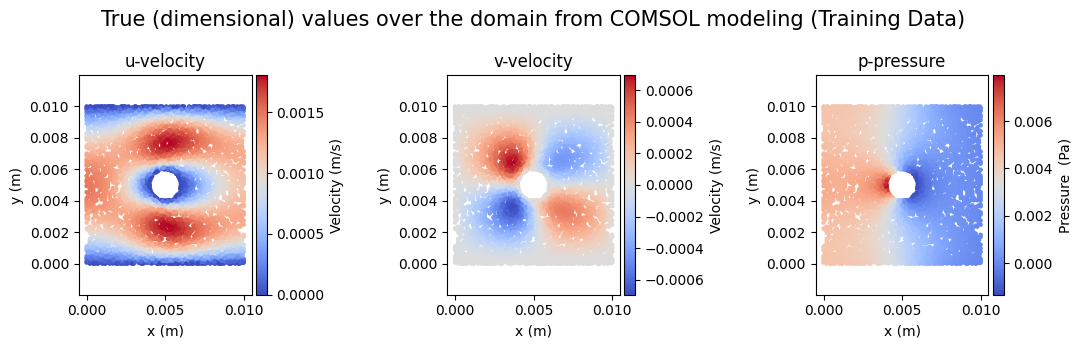

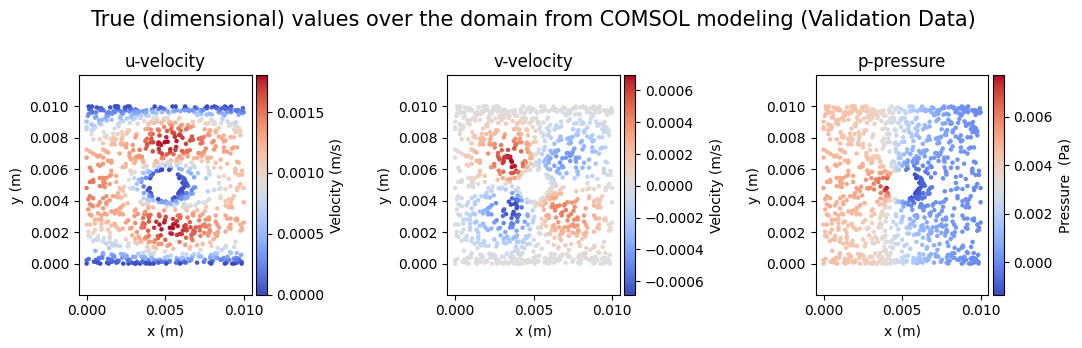

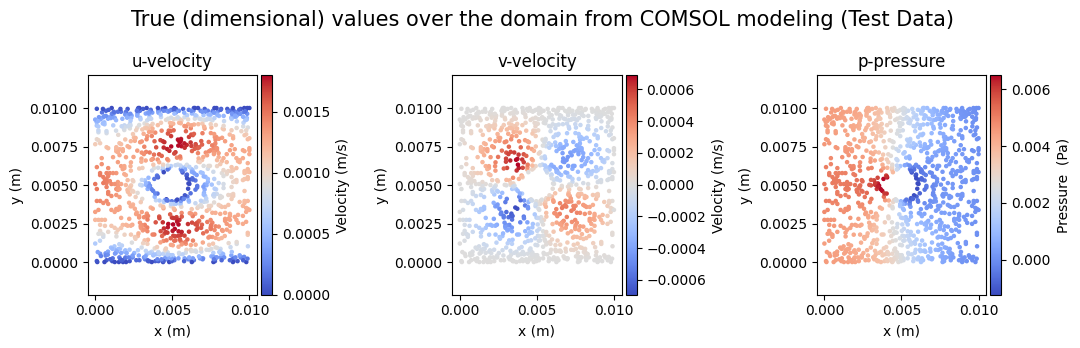

In [3]:
# show the plot of generated data in COMSOL
def show_instance(df, name, form):

    u = df[:, 0]
    v = df[:, 1]
    p = df[:, 2]
    B = df[:, -3]
    x = df[:, -2]
    y = df[:, -1]

    # Create figure and axes
    fig, axs = plt.subplots(1, 3, figsize=(11, 3.5))

    sc_u = axs[0].scatter(x, y, c=u, cmap='coolwarm', s=5, marker='o')
    axs[0].set_title(f'u-velocity')
    axs[0].set_xlabel(f"{'x (m)' if form == '(dimensional)' else 'x'}")
    axs[0].set_ylabel(f"{'y (m)' if form == '(dimensional)' else 'y'}")
    axs[0].axis('equal')

    sc_v = axs[1].scatter(x, y, c=v, cmap='coolwarm', s=5, marker='o')
    axs[1].set_title(f'v-velocity')
    axs[1].set_xlabel(f"{'x (m)' if form == '(dimensional)' else 'x'}")
    axs[1].set_ylabel(f"{'y (m)' if form == '(dimensional)' else 'y'}")
    axs[1].axis('equal')

    sc_p = axs[2].scatter(x, y, c=p, cmap='coolwarm', s=5, marker='o')
    axs[2].set_title(f'p-pressure')
    axs[2].set_xlabel(f"{'x (m)' if form == '(dimensional)' else 'x'}")
    axs[2].set_ylabel(f"{'y (m)' if form == '(dimensional)' else 'y'}")
    axs[2].axis('equal')

    # Add colorbars to each subplot
    cbar_u = fig.colorbar(sc_u, ax=axs[0], location='right', pad=0.02)
    cbar_u.set_label(f"Velocity {'(m/s)' if form == '(dimensional)' else ''}")
    cbar_v = fig.colorbar(sc_v, ax=axs[1], location='right', pad=0.02)
    cbar_v.set_label(f"Velocity {'(m/s)' if form == '(dimensional)' else ''}")
    cbar_p = fig.colorbar(sc_p, ax=axs[2], location='right', pad=0.02)
    cbar_p.set_label(f"Pressure  {'(Pa)' if form == '(dimensional)' else ''}")

    # Set the overall title for the entire figure
    fig.suptitle(f'True {form} values over the domain from COMSOL modeling ({name})', fontsize=15)

    # Layout adjustment and saving the figure
    plt.tight_layout()





# Reading the data from current working directory
current_directory = os.getcwd()
address = os.path.join(current_directory, 'fixed_pressure_outlet.npy')
data = np.load(address)
print(f'Shape of Data:                 {data.shape}')



# splitting the data to train, validation and test
num_points = data.shape[0]
indices = np.random.permutation(num_points)
chosen_data = data[indices[:7000]]
print(f'Shape of the Chosen Data:       {chosen_data.shape}')

training_data = chosen_data[:5000, ...]
print(f'Shape of the Training Data:     {training_data.shape}')

validation_data = chosen_data[5000:6000, ...]
print(f'Shape of Validation Data:       {validation_data.shape}')

test_data = chosen_data[6000:, ...]
print(f'Shape of Test Data:             {test_data.shape}')


show_instance(training_data, 'Training Data', '(dimensional)')
show_instance(validation_data, 'Validation Data', '(dimensional)')
show_instance(test_data, 'Test Data', '(dimensional)')

Reynolds number:   10.0
the entire dataset:   torch.Size([10846, 6])
training_data:   torch.Size([5000, 6])
validation_data:   torch.Size([1000, 6])
test_data:   torch.Size([1000, 6])


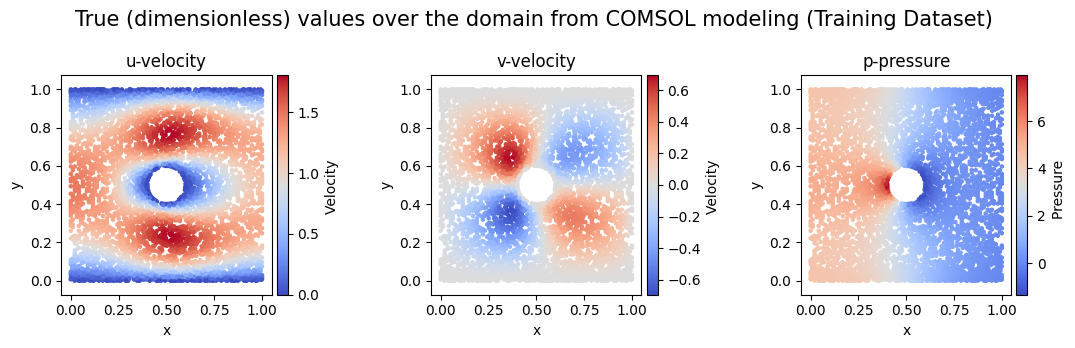

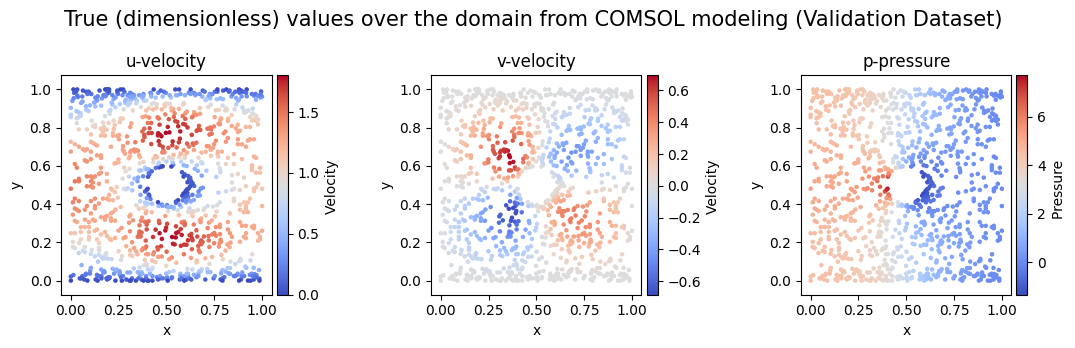

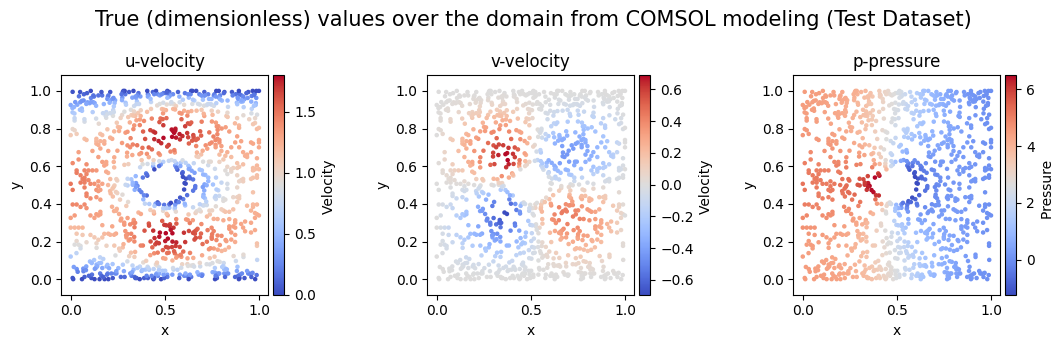

In [4]:
# essential variables
rho = 1.0e3                                                # kg/m^3    (COMSOL simulation assumptions)
mu = 1.0e-3                                                # Pa.s      (COMSOL simulation assumptions)
Lcar = 0.01                                                # m     (characteristic length)
Vref = 0.001                                               # m/s   (reference velocity)

Re = rho * Vref * Lcar / mu                                # Reynolds number
print(f'Reynolds number:   {Re}')



# non-dimensionalize
def non_dimensionalize(value, term, Vref=0, Lcar=0):
    if term == 'length':
       return value / Lcar
    elif term == 'velocity':
       return value / Vref
    elif term == 'pressure':
       return value / (rho * (Vref ** 2))
    else:
      raise NameError(f"Unknown input term: {term}")


# re-dimensionalize
def re_dimensionalize(n_value, term, Vref=0, Lcar=0):
    if term == 'length':
        return n_value * Lcar
    elif term == 'velocity':
        return n_value * Vref
    elif term == 'pressure':
       return n_value * (rho * (Vref ** 2))
    else:
      raise NameError(f"Unknown input term: {term}")



def prepare_dataset_2D(df, title):
   u = non_dimensionalize(df[:, 0], 'velocity', Vref=Vref)
   v = non_dimensionalize(df[:, 1], 'velocity', Vref=Vref)
   p = non_dimensionalize(df[:, 2], 'pressure', Vref=Vref)
   B = df[:, -3] # its a flag, which separates boundary nodes, near boudary nodes and interior nodes
   x = non_dimensionalize(df[:, -2], 'length', Lcar=Lcar)
   y = non_dimensionalize(df[:, -1], 'length', Lcar=Lcar)

   dataset = torch.tensor(np.column_stack((u, v, p, B, x, y)), dtype=torch.float)
   print(f'{title}:   {dataset.size()}')

   return dataset


dataset = prepare_dataset_2D(data, 'the entire dataset')
training_dataset = prepare_dataset_2D(training_data, 'training_data')
validation_dataset = prepare_dataset_2D(validation_data, 'validation_data')
test_dataset = prepare_dataset_2D(test_data, 'test_data')



show_instance(training_dataset, 'Training Dataset', '(dimensionless)')
show_instance(validation_dataset, 'Validation Dataset', '(dimensionless)')
show_instance(test_dataset, 'Test Dataset', '(dimensionless)')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining the collocation points
# training points
x_tr = training_dataset[:, -2].to(device, non_blocking=True)                                     # x_in training DD
y_tr = training_dataset[:, -1].to(device, non_blocking=True)                                     # y_in training DD
u_tr = training_dataset[:, 0].to(device, non_blocking=True)                                      # u_true training DD
v_tr = training_dataset[:, 1].to(device, non_blocking=True)                                      # v_true training DD
p_tr = training_dataset[:, 2].to(device, non_blocking=True)                                      # p_true training DD
uvp_tr = torch.column_stack((u_tr, v_tr, p_tr))

# validation points
x_va = validation_dataset[:, -2].to(device, non_blocking=True)                                   # x_in validation DD
y_va = validation_dataset[:, -1].to(device, non_blocking=True)                                   # y_in validation DD
u_va = validation_dataset[:, 0].to(device, non_blocking=True)                                    # u_true validation
v_va = validation_dataset[:, 1].to(device, non_blocking=True)                                    # v_true validation
p_va = validation_dataset[:, 2].to(device, non_blocking=True)                                    # p_true validation
uvp_va = torch.column_stack((u_va, v_va, p_va))





# defining the model architecture
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.net_u = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
            )

        self.net_v = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
            )

        self.net_p = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
            )

        # self.double()                     # Use double precision (float64)

        # Initialize weights with a coefficient
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=1.0)  # Apply the coefficient
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.01)

    def forward(self, x) -> torch.Tensor:
        u = self.net_u(x)
        v = self.net_v(x)
        p = self.net_p(x)
        return torch.column_stack((u, v, p))



model = SimpleNet().to(device, non_blocking=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
summary(model, input_size=(1000, 2))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1000, 64]             192
              Tanh-2             [-1, 1000, 64]               0
            Linear-3             [-1, 1000, 64]           4,160
              Tanh-4             [-1, 1000, 64]               0
            Linear-5             [-1, 1000, 64]           4,160
              Tanh-6             [-1, 1000, 64]               0
            Linear-7              [-1, 1000, 1]              65
            Linear-8             [-1, 1000, 64]             192
              Tanh-9             [-1, 1000, 64]               0
           Linear-10             [-1, 1000, 64]           4,160
             Tanh-11             [-1, 1000, 64]               0
           Linear-12             [-1, 1000, 64]           4,160
             Tanh-13             [-1, 1000, 64]               0
           Linear-14              [-1, 

In [6]:
# data-driven loss:
def compute_data_driven_loss(dimless_pred, dimless_obsd):
    mse_u = torch.mean(torch.square(dimless_pred[:, 0] - dimless_obsd[:, 0]))
    mse_v = torch.mean(torch.square(dimless_pred[:, 1] - dimless_obsd[:, 1]))
    mse_p = torch.mean(torch.square(dimless_pred[:, 2] - dimless_obsd[:, 2]))

    mse = mse_u + mse_v + mse_p
    return mse, (mse_u, mse_v, mse_p)



data_driven_loss_list = []
dd_loss_u = []
dd_loss_v = []
dd_loss_p = []

data_driven_vloss_list = []


# defininf training pipeline
def closure():
    ##### training #####:
    # Set model to training mode
    model.train()

    ##### Zero the gradients #####
    optimizer.zero_grad()

    ##### Forward pass #####
    dd_inp = torch.column_stack((x_tr, y_tr))
    data_driven_loss, dd_loss_components = compute_data_driven_loss(dimless_pred = model(dd_inp), dimless_obsd = uvp_tr)
    loss_u = dd_loss_components[0]
    loss_v = dd_loss_components[1]
    loss_p = dd_loss_components[2]

    ##### Backward pass #####
    data_driven_loss.backward()

    ##### Clip gradients to prevent exploding gradients (max_grad_norm = 1.0)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # store calculated training loss
    data_driven_loss_list.append(data_driven_loss.item())
    dd_loss_u.append(loss_u.item())
    dd_loss_v.append(loss_v.item())
    dd_loss_p.append(loss_p.item())

    ##### validation #####:
    # Set the model to evaluation mode
    model.eval()

    ##### Forward pass #####
    dd_inp_va = torch.column_stack((x_va, y_va))
    data_driven_vloss, dd_vloss_components = compute_data_driven_loss(dimless_pred = model(dd_inp_va), dimless_obsd = uvp_va)

    # store calculated validation loss
    data_driven_vloss_list.append(data_driven_vloss.item())

    return data_driven_loss



# the training pipeline:
def fit(num_epochs):
    for epoch in range(num_epochs):
        optimizer.step(closure)

        if epoch % 1000 == 0:
            print("=================================================================================================================================================================================================")
            print(f"epoch:{epoch+1}/{num_epochs}>  DD_loss: {data_driven_loss_list[-1]:.9f}   DD_vloss:{data_driven_vloss_list[-1]:.9f}")

    history = {
        "history": (data_driven_loss_list, (dd_loss_u, dd_loss_v, dd_loss_p)),
        "val_history": (data_driven_vloss_list)
    }

    return history

In [7]:
# metrics_and_plots_2d
def plot_loss(loss, val_loss):

    Data_Driven_loss = np.array(loss[0])
    dd_u = np.array(loss[1][0])
    dd_v = np.array(loss[1][1])
    dd_p = np.array(loss[1][2])

    Data_Driven_Val_loss = np.array(val_loss)

    n_epochs = np.arange(int(len(loss[0])))

    # Create figure and axes
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))

    axs[0].plot(n_epochs, Data_Driven_loss, label="Training Loss")
    axs[0].plot(n_epochs, Data_Driven_Val_loss, label="Validation Loss")
    axs[0].set_title('Data Driven Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_yscale('log')  # Set y-axis to logarithmic scale

    axs[1].plot(n_epochs, dd_u, label="Training Loss (u)")
    axs[1].plot(n_epochs, dd_v, label="Training Loss (v)")
    axs[1].plot(n_epochs, dd_p, label="Training Loss (p)")
    axs[1].set_title('Data Driven Loss components')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].set_yscale('log')  # Set y-axis to logarithmic scale

    # Layout adjustment and saving the figure
    plt.tight_layout()

    results_folder = "results"
    os.makedirs(results_folder, exist_ok=True)

    # Get the current date and time
    now = datetime.datetime.now()
    # Format the timestamp as a string (e.g., "2024-06-01_18-24-41")
    timestamp_str = now.strftime("%Y-%m-%d___%H-%M-%S")
    file_name = f"Computed Losses {timestamp_str}.png"

    # Save the figure to a file inside the folder
    file_path = os.path.join(results_folder, file_name)
    plt.savefig(file_path, dpi=300)

    print(f"Plot saved as {file_name}")



def plot_domain_error(model, test_dataset, size):
    device = torch.device("cpu")
    model.to(device, non_blocking=True).eval()

    n_observation = test_dataset[:, :3]
    n_prediction = model(test_dataset[:, -2:])

    u_obsd = n_observation[:, 0]
    v_obsd = n_observation[:, 1]
    p_obsd = n_observation[:, 2]

    u_pred = n_prediction[:, 0]
    v_pred = n_prediction[:, 1]
    p_pred = n_prediction[:, 2]

    B = test_dataset[:, -3]
    x = test_dataset[:, -2]
    y = test_dataset[:, -1]

    error_u = torch.abs(u_pred - u_obsd)
    error_v = torch.abs(v_pred - v_obsd)
    error_p = torch.abs(p_pred - p_obsd)

    errors = [error_u, error_v, error_p]
    preds = [u_pred, v_pred, p_pred]
    obsds = [u_obsd, v_obsd, p_obsd]


    def sub_func_domain_error(preds, obsds, errors, feature):

        if feature == 'u':
            normed_pred, normed_observed, error = preds[0], obsds[0], errors[0]
        elif feature == 'v':
            normed_pred, normed_observed, error = preds[1], obsds[1], errors[1]
        elif feature == 'p':
            normed_pred, normed_observed, error = preds[2], obsds[2], errors[2]

        # Create figure and axes
        fig, axs = plt.subplots(1, 3, figsize=(14, 4.5))

        sc_tr = axs[0].scatter(x, y, c= normed_observed.detach().numpy(), cmap='coolwarm', s=size, marker='o')
        axs[0].set_title(f'COMSOL observation {feature}')
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('y')
        axs[0].axis('equal')
        cbar_u_tr = fig.colorbar(sc_tr, ax=axs[0], location='right', pad=0.02)
        cbar_u_tr.set_label('dimensionless range')

        sc_pr = axs[1].scatter(x, y, c= normed_pred.detach().numpy(), cmap='coolwarm', s=size, marker='o')
        axs[1].set_title(f'MODEL prediction {feature}')
        axs[1].set_xlabel('x')
        axs[1].set_ylabel('y')
        axs[1].axis('equal')
        cbar_u_pr = fig.colorbar(sc_pr, ax=axs[1], location='right', pad=0.02)
        cbar_u_pr.set_label('dimensionless range')

        sc_u = axs[2].scatter(x, y, c= error.detach().numpy(), cmap='coolwarm', s=size, marker='o')
        axs[2].set_title(f'Absolute Error {feature}')
        axs[2].set_xlabel('x')
        axs[2].set_ylabel('y')
        axs[2].axis('equal')
        cbar_u = fig.colorbar(sc_u, ax=axs[2], location='right', pad=0.02)
        cbar_u.set_label(f'AE {feature}')


        # Set the overall title for the entire figure
        sup_title = f'Observation, Prediction & Absolute Error (AE) for the entire nodes'
        fig.suptitle(f'{sup_title.upper()}', fontsize=16)

        # Layout adjustment and saving the figure
        #plt.tight_layout()
        fig.tight_layout()

        results_folder = "results"
        os.makedirs(results_folder, exist_ok=True)

        # Get the current date and time
        now = datetime.datetime.now()
        # Format the timestamp as a string (e.g., "2024-06-01_18-24-41")
        timestamp_str = now.strftime("%Y-%m-%d___%H-%M-%S")
        file_name = f"prediction error {feature} over domain_{timestamp_str}.png"

        # Save the figure to a file inside the folder
        file_path = os.path.join(results_folder, file_name)
        plt.savefig(file_path, dpi=300)

        print(f"Plot saved as {file_name}")


    sub_func_domain_error(preds, obsds, errors, 'u')
    sub_func_domain_error(preds, obsds, errors, 'v')
    sub_func_domain_error(preds, obsds, errors, 'p')



def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate mean absolute percentage error and symmetric mean absolute percentage error.
    Exclude zero denominators in the calculation of MAPE.
    Calculate sMAPE for all values.

    :param y_true: Array of observed values
    :param y_pred: Array of predicted values
    :return: MAPE, sMAPE
    """
    # Calculation for sMAPE
    if isinstance(y_pred, torch.Tensor):
        denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2
        non_zero_denominator_mask = denominator != 0
        smape = torch.mean(torch.abs(y_true[non_zero_denominator_mask] - y_pred[non_zero_denominator_mask]) / denominator[non_zero_denominator_mask]) * 100

    return smape



def r2_score(y_true, y_pred):
    """
    Calculate R-squared (coefficient of determination) score.

    :param y_true: Array of observed values
    :param y_pred: Array of predicted values
    :return: R^2 score
    """
    if isinstance(y_pred, torch.Tensor):
        # Mean of observed data
        mean_true = torch.mean(y_true)
        # Total sum of squares
        total_sum_of_squares = torch.sum((y_true - mean_true) ** 2)
        # Residual sum of squares
        residual_sum_of_squares = torch.sum((y_true - y_pred) ** 2)
        # R^2 score calculation
        r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)

    return r2



def mean_bias_deviation(y_true, y_pred):
    """
    Calculate Mean Bias Deviation (MBD).

    :param y_true: Array of observed values
    :param y_pred: Array of predicted values
    :return: MBD
    """
    # Convert PyTorch tensor to NumPy array if it isn't already
    if isinstance(y_pred, torch.Tensor):
        # Calculate MBD
        mbd = torch.mean(y_pred - y_true)

    return mbd



def plot_true_vs_predicted(y_true, y_pred, feature):
    """
    Create a plot with 2 subplots based on y_true, y_pred:
    1) Overlay the histograms of y_true and y_pred.
    2) Plot a histogram of the errors (y_pred - y_true).
    Save the plot as a PNG file.

    :param y_true: Array of observed values
    :param y_pred: Array of predicted values
    :param idx: Identifier for the output file name
    """
    # Convert PyTorch tensor to NumPy array if it isn't already
    if isinstance(y_pred, torch.Tensor):
      y_true, y_pred = y_true.detach().numpy(), y_pred.detach().numpy()

    errors = y_pred - y_true


    # Create figure and axes
    fig, axs = plt.subplots(3, 1, figsize=(8, 15))

    # Subplot 1: Overlayed Histograms of y_true and y_pred
    axs[0].hist(y_true, bins=20, alpha=0.7, label='True Values')
    axs[0].hist(y_pred, bins=20, alpha=0.7, label='Predicted Values')
    axs[0].set_title(f'True vs Predicted Values (the entire nodes {feature})')
    axs[0].set_xlabel('Values')
    axs[0].set_ylabel('Frequency')
    axs[0].legend()

    # Subplot 2: Histogram of Errors
    axs[1].hist(errors, bins=20, color='orange', alpha=0.7)
    axs[1].set_title(f'Histogram of Prediction Errors (the entire nodes {feature})')
    axs[1].set_xlabel('Error')
    axs[1].set_ylabel('Frequency')

    # Subplot 3: Scatterplot of y_true vs y_pred
    axs[2].scatter(y_true, y_pred, alpha=0.7, color='green')
    axs[2].set_title(f'Scatterplot of True vs Predicted Values (the entire nodes {feature})')
    axs[2].set_xlabel('True Values')
    axs[2].set_ylabel('Predicted Values')


    # Line of perfect match
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    axs[2].plot([min_val, max_val], [min_val, max_val], 'k--')  # Black dashed line


    # Layout adjustment and saving the figure
    plt.tight_layout()

    results_folder = "results"
    os.makedirs(results_folder, exist_ok=True)

    # Get the current date and time
    now = datetime.datetime.now()
    # Format the timestamp as a string (e.g., "2024-06-01_18-24-41")
    timestamp_str = now.strftime("%Y-%m-%d___%H-%M-%S")
    file_name = f"histogram_the entire nodes {feature}_{timestamp_str}.png"

    # Save the figure to a file inside the folder
    file_path = os.path.join(results_folder, file_name)
    plt.savefig(file_path, dpi=300)

    print(f"Plot saved as {file_name}")



##### Evaluate Steady-State Model #####
def model_evaluation(model, test_dataset):
    # determine avaiable device
    device = torch.device("cpu")
    model.to(device, non_blocking=True).eval()

    n_observation = test_dataset[:, :3]
    n_prediction = model(test_dataset[:, -2:])

    u_pred = n_prediction[:, 0]
    v_pred = n_prediction[:, 1]
    p_pred = n_prediction[:, 2]
    B = test_dataset[:, -3].unsqueeze(1)

    u_obsd = n_observation[:, 0]
    v_obsd = n_observation[:, 1]
    p_obsd = n_observation[:, 2]


    # Statistics
    mape_u = mean_absolute_percentage_error(u_obsd, u_pred)
    mape_v = mean_absolute_percentage_error(v_obsd, v_pred)
    mape_p = mean_absolute_percentage_error(p_obsd, p_pred)

    r2_u = r2_score(u_obsd, u_pred)
    r2_v = r2_score(v_obsd, v_pred)
    r2_p = r2_score(p_obsd, p_pred)

    mbd_u = mean_bias_deviation(u_obsd, u_pred)
    mbd_v = mean_bias_deviation(v_obsd, v_pred)
    mbd_p = mean_bias_deviation(p_obsd, p_pred)

    results_string_mape = f"MAPE(U): {mape_u:.9f}   MAPE(V): {mape_v:.9f}   MAPE(P): {mape_p:.9f}"
    result_string_r2 = f"R2(U): {r2_u:.9f}   R2(V): {r2_v:.9f}   R2(P): {r2_p:.9f}"
    results_string_mbd = f"MBD(U): {mbd_u:.9f}   MBD(V): {mbd_v:.9f}   MBD(P): {mbd_p:.9f}"

    results_folder = "results"
    os.makedirs(results_folder, exist_ok=True)

    # Write the results to a file
    # Get the current date and time
    now = datetime.datetime.now()
    # Format the timestamp as a string (e.g., "2024-06-01_18-24-41")
    timestamp_str = now.strftime("%Y-%m-%d___%H-%M-%S")

    with open(f"results/evaluation results_{timestamp_str}.txt", "w") as file:
        file.write("\nMean Absolute Percentage Error:\n")
        file.write(results_string_mape)
        file.write("\n\nR^2 Score:\n")
        file.write(result_string_r2)
        file.write("\n\nMean Bias Deviation:\n")
        file.write(results_string_mbd)


    print("*********************************************************************************\n",
        results_string_mape,
        "\n*********************************************************************************\n",
        result_string_r2,
        "\n*********************************************************************************\n",
        results_string_mbd,
        "\n*********************************************************************************\n")

    print(f"Results saved successfully to evaluation results.txt\n")

    # Plot true vs predicted
    plot_true_vs_predicted(u_obsd.unsqueeze(1), u_pred.unsqueeze(1),'u')
    plot_true_vs_predicted(v_obsd.unsqueeze(1), v_pred.unsqueeze(1),'v')
    plot_true_vs_predicted(p_obsd.unsqueeze(1), p_pred.unsqueeze(1),'p')

In [8]:
history = fit(100001)

epoch:1/100001>  DD_loss: 9.941679001   DD_vloss:9.947206497
epoch:1001/100001>  DD_loss: 0.005780031   DD_vloss:0.006257626
epoch:2001/100001>  DD_loss: 0.002679343   DD_vloss:0.003129781
epoch:3001/100001>  DD_loss: 0.003423457   DD_vloss:0.003680633
epoch:4001/100001>  DD_loss: 0.001493055   DD_vloss:0.001855217
epoch:5001/100001>  DD_loss: 0.001082277   DD_vloss:0.001338632
epoch:6001/100001>  DD_loss: 0.001354804   DD_vloss:0.001506594
epoch:7001/100001>  DD_loss: 0.000646335   DD_vloss:0.000809903
epoch:8001/100001>  DD_loss: 0.000609233   DD_vloss:0.000747983
epoch:9001/100001>  DD_loss: 0.000856476   DD_vloss:0.001006314
epoch:10001/100001>  DD_loss: 0.000640735   DD_vloss:0.000746694
epoch:11001/100001>  DD_loss: 0.000430537   DD_vloss:0.000527164
epoch:12001/100001>  DD_loss: 0.000273426   DD_vloss:0.000349680
epoch:13001/100001>  DD_loss: 0.000236627   DD_vloss:0.000305142
epoch:14001/100001>  DD_loss: 0.000241226   DD_vloss:0.000305842
epoch:15001/100001>  DD_loss: 0.000255

Plot saved as Computed Losses 2025-01-25___18-36-51.png
Plot saved as prediction error u over domain_2025-01-25___18-36-54.png
Plot saved as prediction error v over domain_2025-01-25___18-36-56.png
Plot saved as prediction error p over domain_2025-01-25___18-36-57.png
Plot saved as prediction error u over domain_2025-01-25___18-36-59.png
Plot saved as prediction error v over domain_2025-01-25___18-37-01.png
Plot saved as prediction error p over domain_2025-01-25___18-37-05.png
*********************************************************************************
 MAPE(U): 6.928648949   MAPE(V): 18.366340637   MAPE(P): 2.132378340 
*********************************************************************************
 R2(U): 0.999986410   R2(V): 0.999975204   R2(P): 0.999997020 
*********************************************************************************
 MBD(U): 0.000002345   MBD(V): -0.000416952   MBD(P): -0.000741569 
***********************************************************************

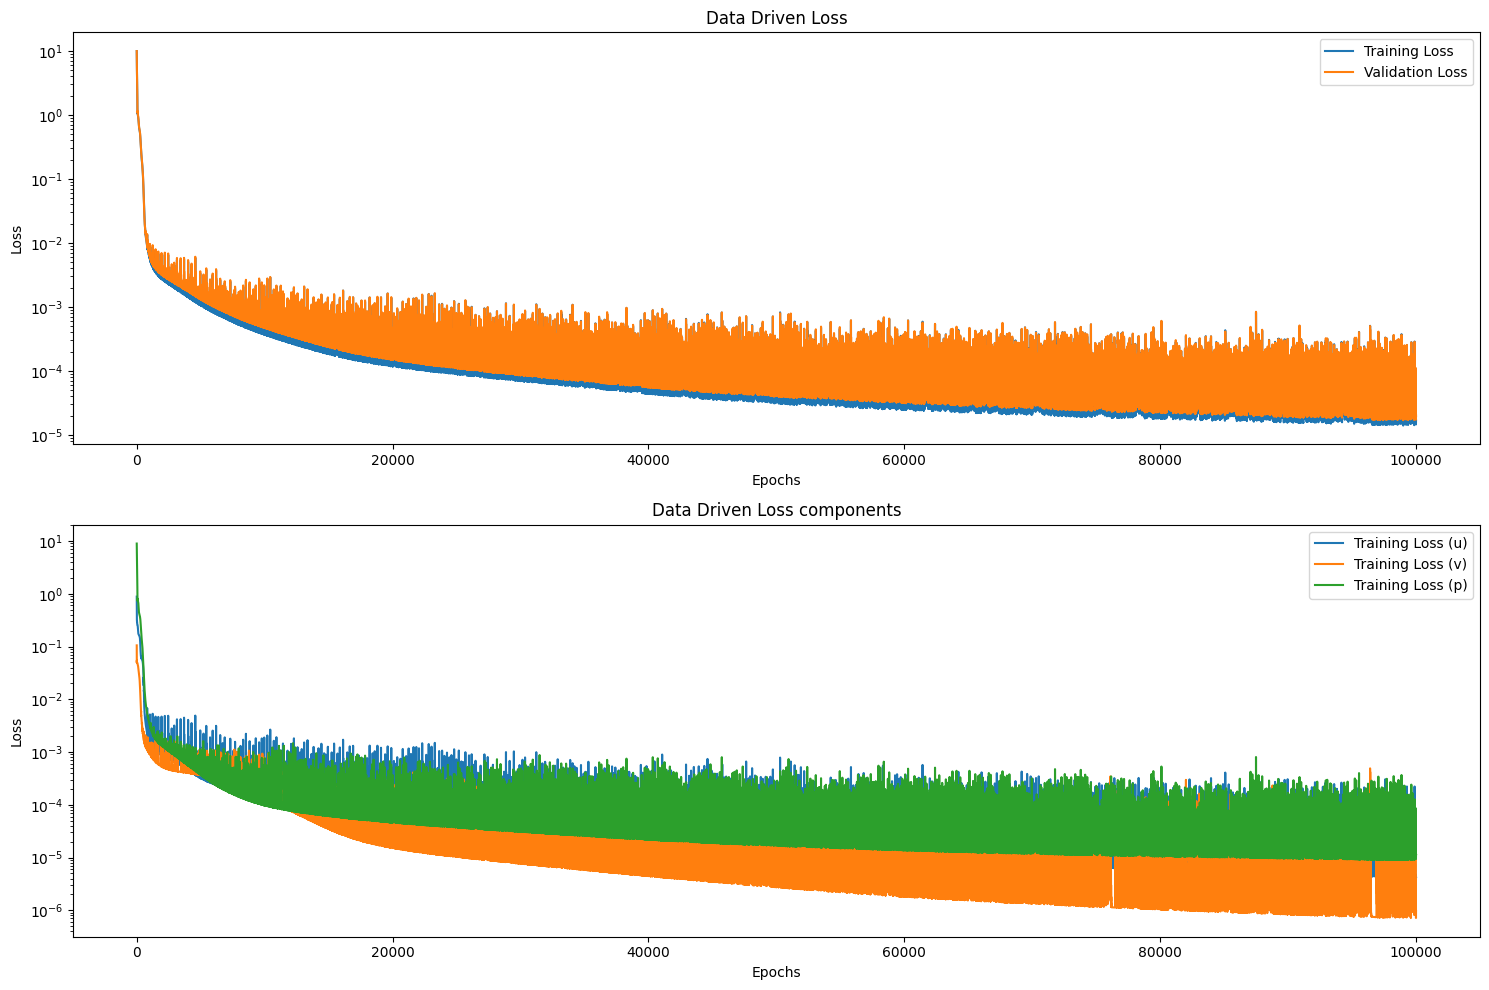

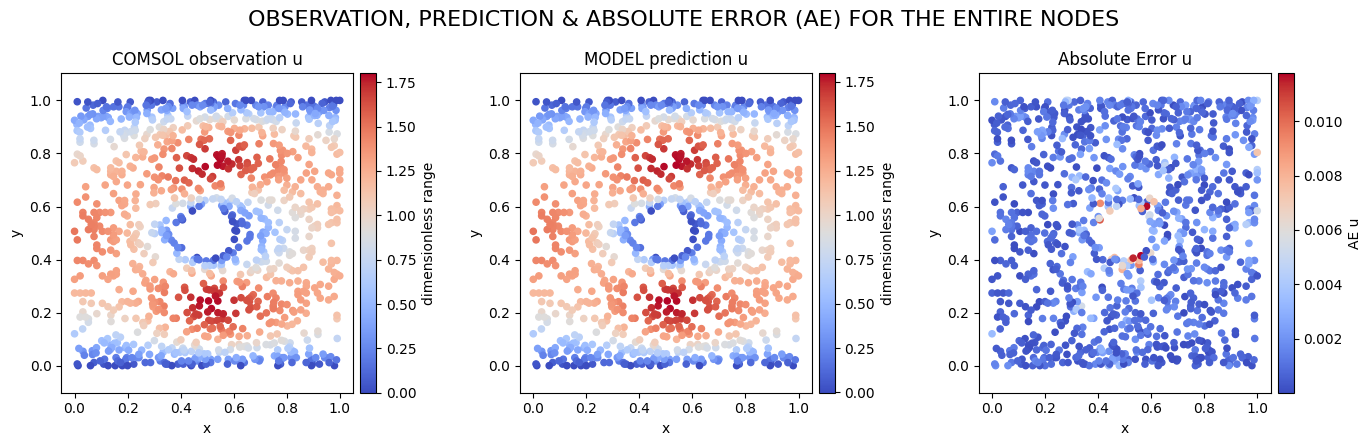

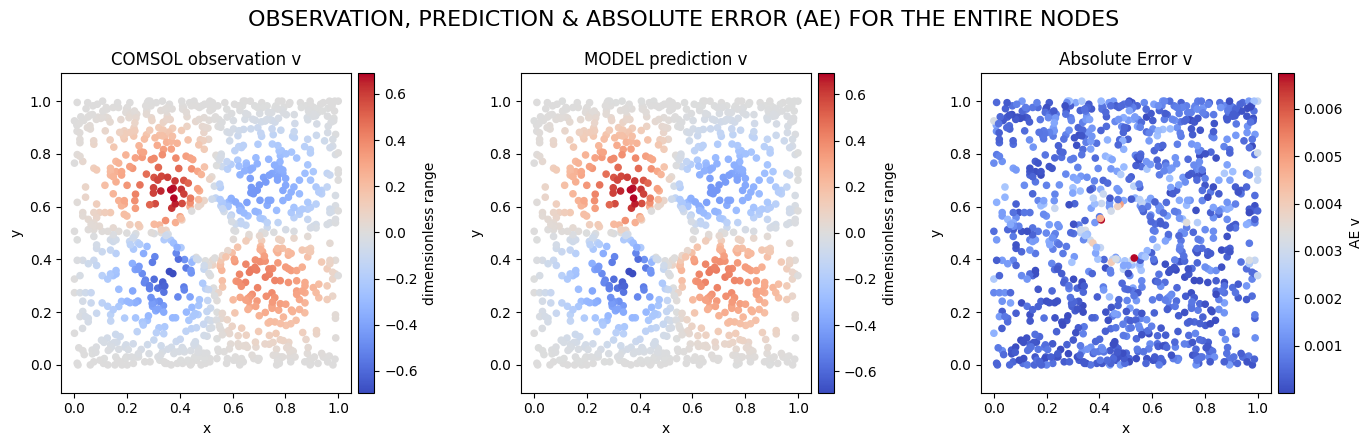

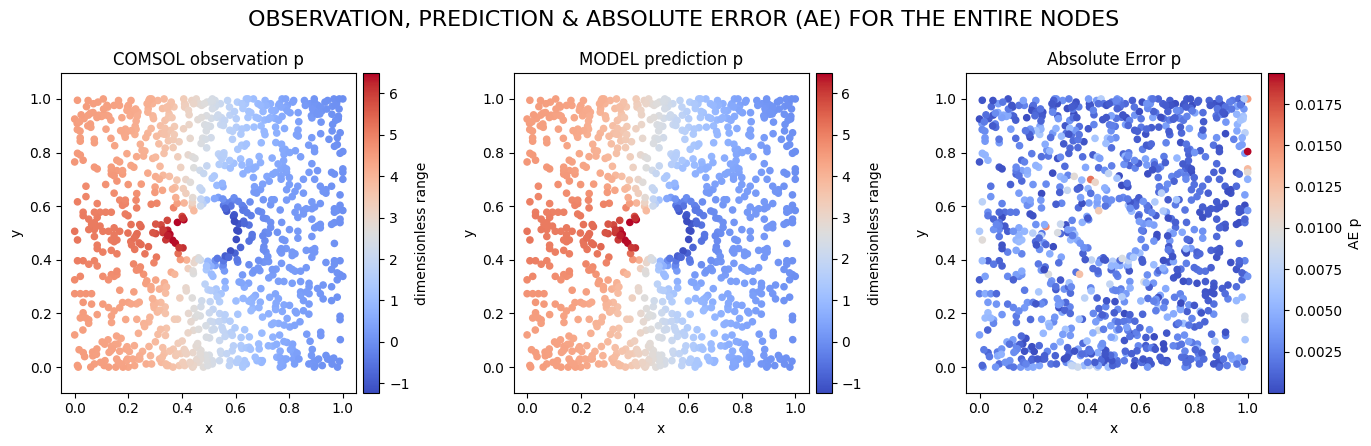

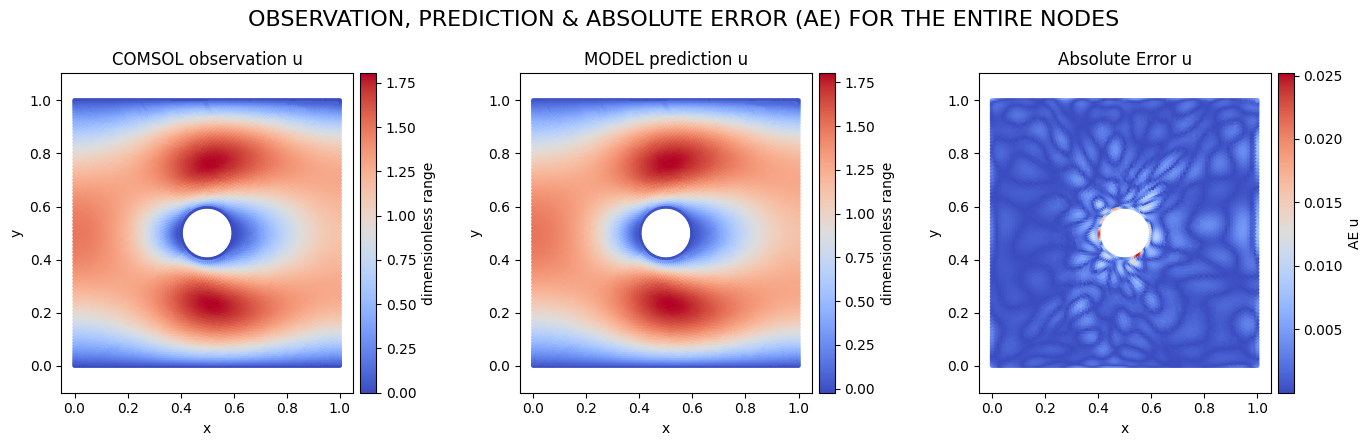

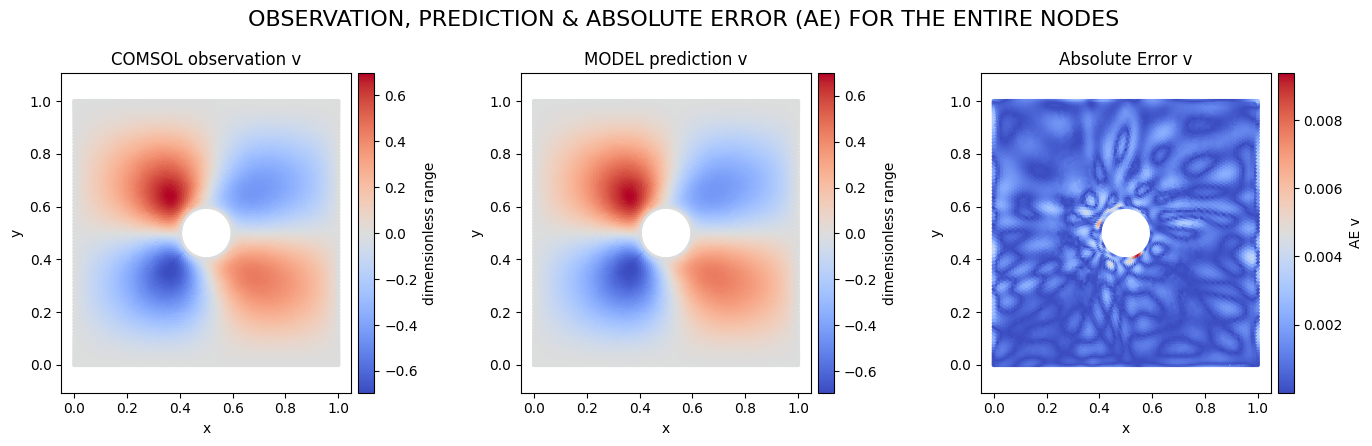

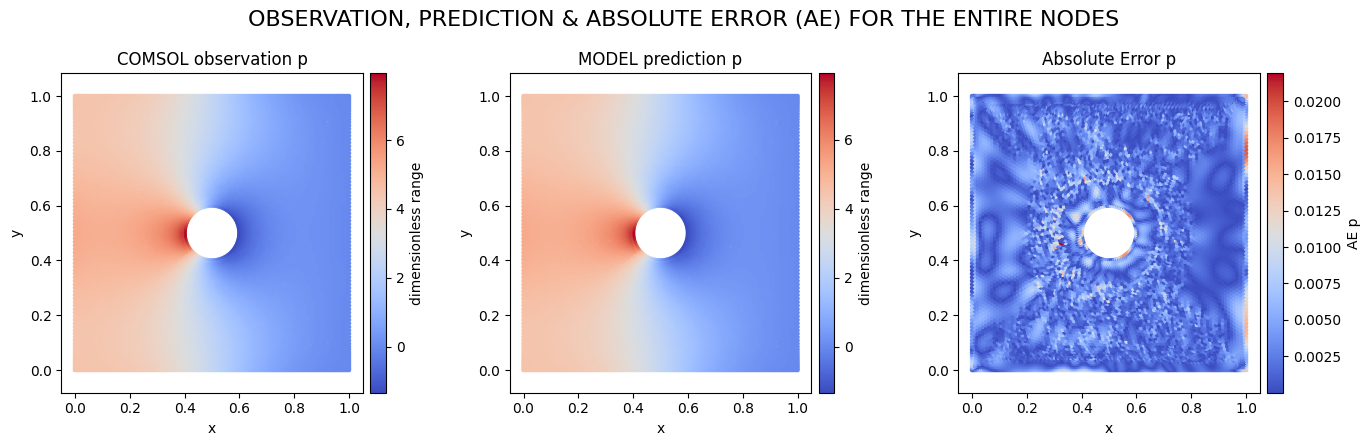

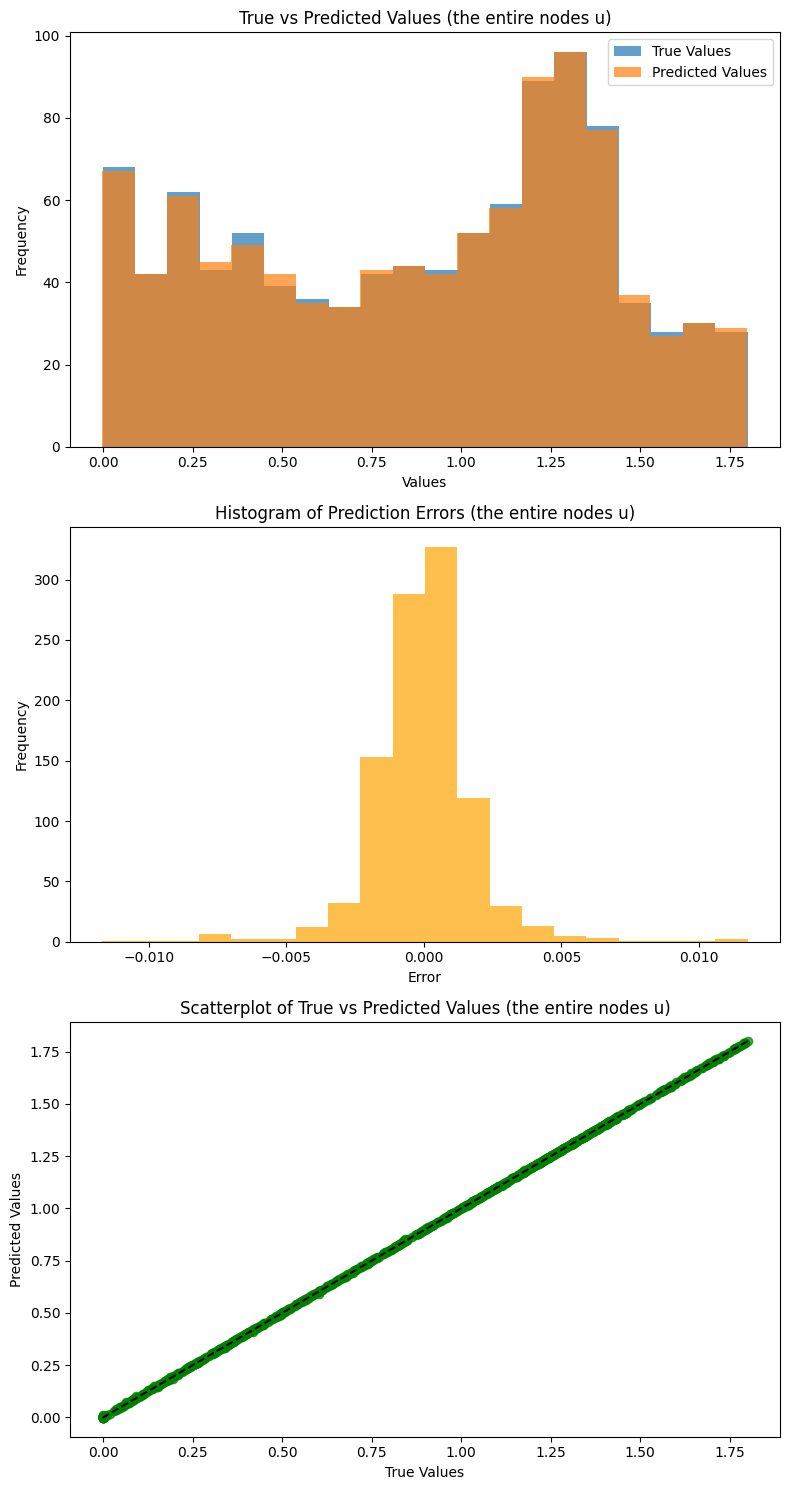

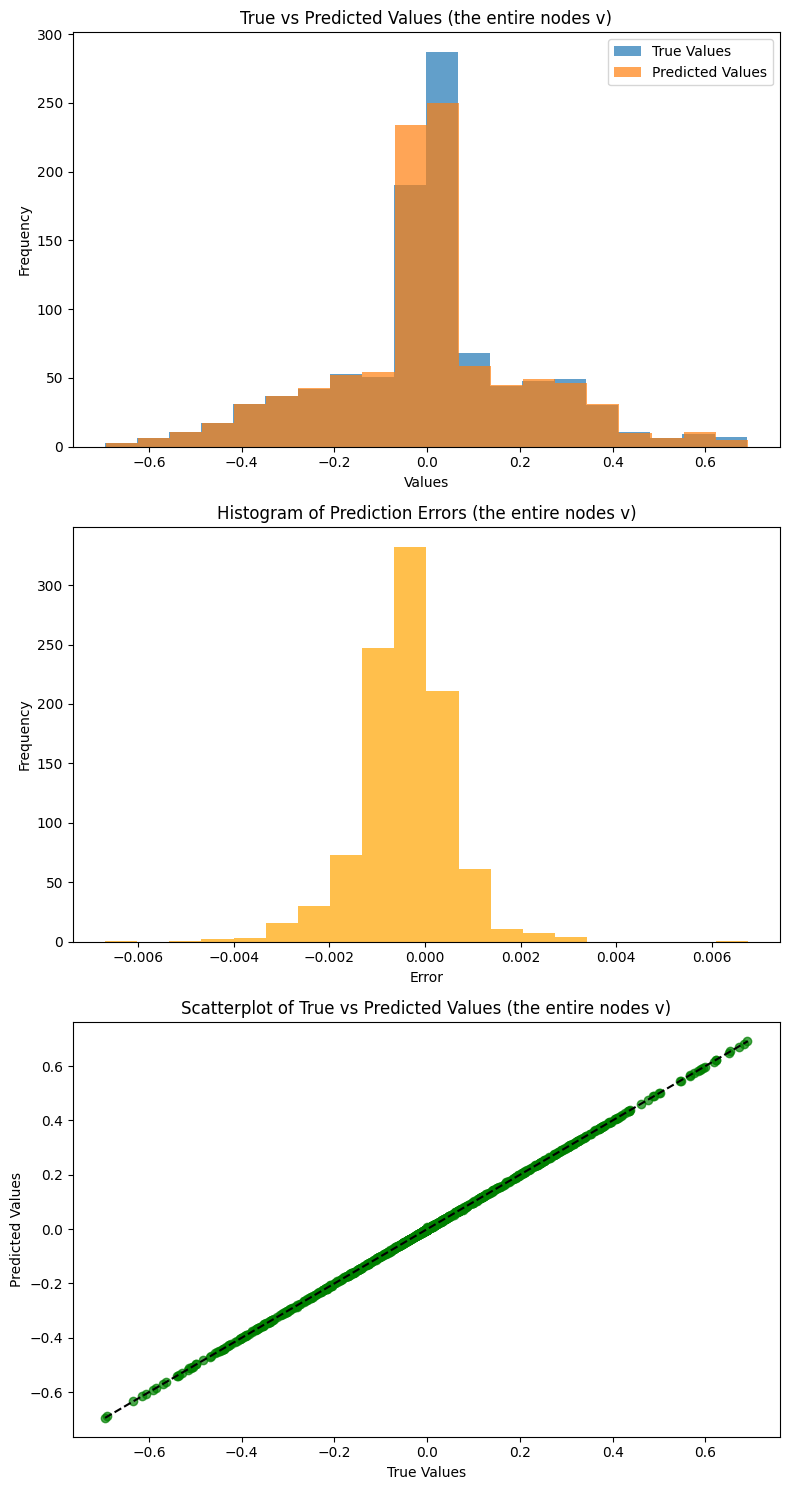

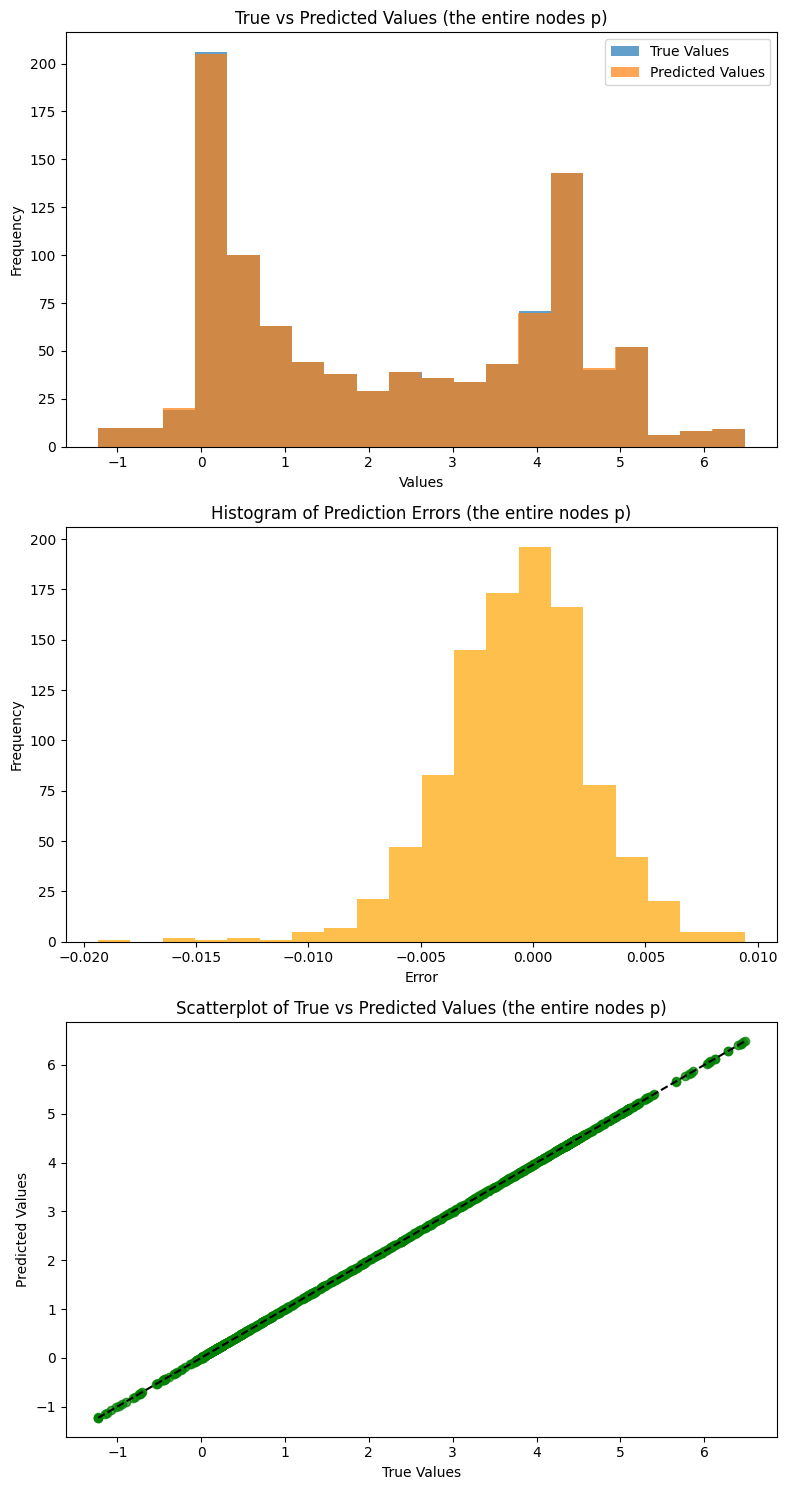

In [9]:
plot_loss(loss = history["history"],
          val_loss = history["val_history"])

plot_domain_error(model, test_dataset, 20)

plot_domain_error(model, dataset, 5)

model_evaluation(model, test_dataset)